In [15]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import umap.umap_ as umap
import cv2
from tensorflow.keras.models import Model

In [2]:
# Function to load MNIST images from idx file
def load_idx_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack('>IIII', f.read(16))  # Read metadata
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols, 1)  # Read images
    return data.astype(np.float32) / 255.0  # Normalize between 0 and 1

# Function to load MNIST labels from idx file
def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack('>II', f.read(8))  # Read metadata
        labels = np.frombuffer(f.read(), dtype=np.uint8)  # Read labels
    return labels

In [3]:
# Load train and test data
train_images = load_idx_images("train-images.idx3-ubyte")
train_labels = load_idx_labels("train-labels.idx1-ubyte")
test_images = load_idx_images("t10k-images.idx3-ubyte")
test_labels = load_idx_labels("t10k-labels.idx1-ubyte")

# Print dataset shapes
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (60000, 28, 28, 1)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28, 1)
Test Labels Shape: (10000,)


In [4]:
def residual_block(x, filters):
    skip = x  # Save input for skip connection
    
    # If input channels don't match output channels, apply a 1x1 convolution to match
    if x.shape[-1] != filters:
        skip = layers.Conv2D(filters, (1, 1), padding='same', activation=None)(skip)

    x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, skip])  # Skip connection
    x = layers.ReLU()(x)
    return x

def build_encoder():
    input_img = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = residual_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(input_img, x, name="ResNet_Encoder")

def build_decoder():
    latent_input = layers.Input(shape=(64,))
    x = layers.Dense(256 * 7 * 7, activation='relu')(latent_input)
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(x)
    
    return models.Model(latent_input, x, name="ResNet_Decoder")

# Build models
encoder = build_encoder()
decoder = build_decoder()

# Autoencoder
autoencoder = models.Model(encoder.input, decoder(encoder.output), name="ResNet_Autoencoder")

# Compile
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Summaries
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "ResNet_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │    147,584 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 14, 14,    │          0 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 7, 7, 256) │    590,080 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 256) │     33,024 │ max_pooling2d_1[

 Total params: 3,127,553 (11.93 MB)

 Trainable params: 3,126,017 (11.92 MB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "ResNet_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14, 14,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │    147,584 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 14, 14,    │          0 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 7, 7, 256) │    590,080 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 256) │     33,024 │ max_pooling2d_1[

 Total params: 1,168,192 (4.46 MB)

 Trainable params: 1,166,656 (4.45 MB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "ResNet_Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12544)          │       815,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 7, 7, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959,361 (7.47 MB)

 Trainable params: 1,959,361 (7.47 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train Autoencoder (Unsupervised Learning)
autoencoder.fit(train_images, train_images, epochs=5, batch_size=32, shuffle=True)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 156s 82ms/step - loss: 0.1675
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 154s 82ms/step - loss: 0.0903
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 253s 135ms/step - loss: 0.0813
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 278s 148ms/step - loss: 0.0771
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 281s 150ms/step - loss: 0.0746


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


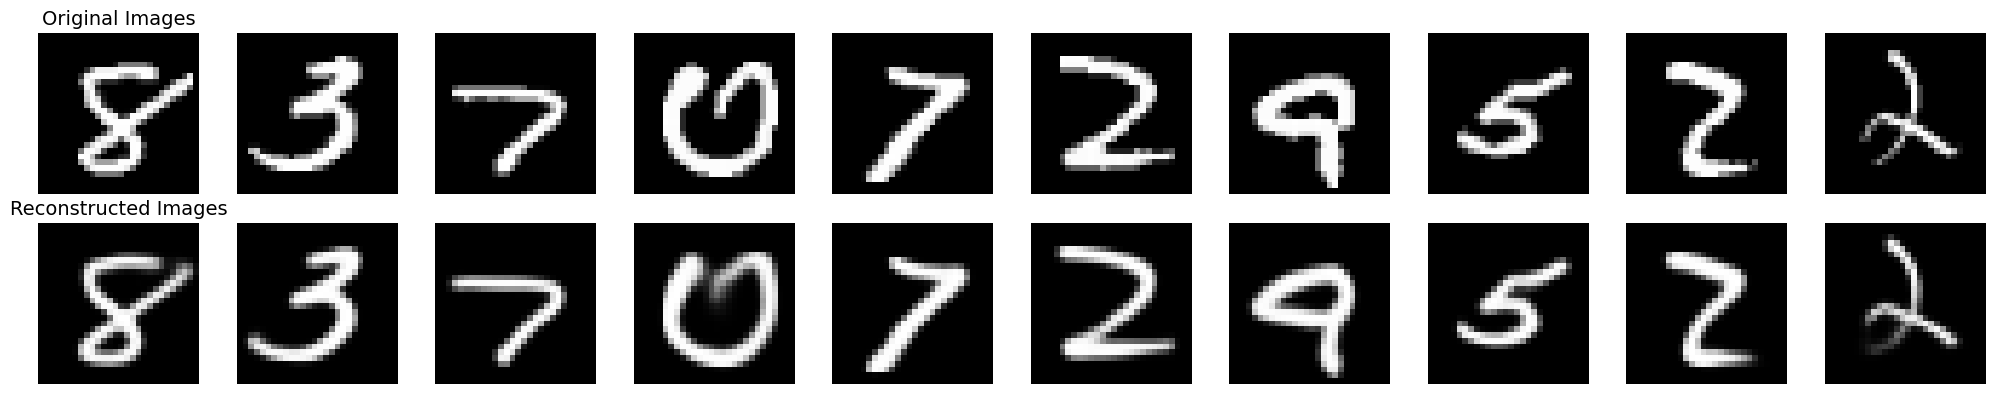

In [6]:
# Select random images from the dataset
num_images = 10  # Number of images to display
random_indices = np.random.choice(len(train_images), num_images, replace=False)

# Encode and decode the images
encoded_imgs = encoder.predict(train_images[random_indices])  # Pass through encoder
decoded_imgs = decoder.predict(encoded_imgs)  # Pass through decoder

# Plot the images: original vs. reconstructed
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

for i in range(num_images):
    # Original images
    axes[0, i].imshow(train_images[random_indices[i]].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original Images", fontsize=14)
axes[1, 0].set_title("Reconstructed Images", fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
# Extract Features Using Encoder
encoded_train = encoder.predict(train_images)
encoded_test = encoder.predict(test_images)

# Reduce to 5D using UMAP
umap_5d = umap.UMAP(n_components=8, random_state=42)
encoded_train_5d = umap_5d.fit_transform(encoded_train)
encoded_test_5d = umap_5d.transform(encoded_test)

num_clusters = 10  # Adjust based on variation in styles
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
gmm.fit(encoded_train_5d)

# Assign clusters to training and test data
train_clusters = gmm.predict(encoded_train_5d)
test_clusters = gmm.predict(encoded_test_5d)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the num

In [9]:
from scipy.stats import mode

# Assign labels to clusters based on most frequent digit
def assign_labels(clusters, true_labels):
    label_map = {}
    for i in range(num_clusters):
        mask = (clusters == i)  # Select points in cluster i
        if np.sum(mask) == 0:
            label_map[i] = -1  # No samples in cluster
        else:
            most_common = mode(true_labels[mask])[0]  # Most frequent digit
            label_map[i] = most_common
    return label_map

cluster_to_label = assign_labels(train_clusters, train_labels)
predicted_labels = np.array([cluster_to_label[c] for c in test_clusters])

# Evaluate Clustering Performance
accuracy = np.mean(predicted_labels == test_labels)
print(f"GMM Classification Accuracy: {accuracy * 100:.2f}%")


GMM Classification Accuracy: 97.43%


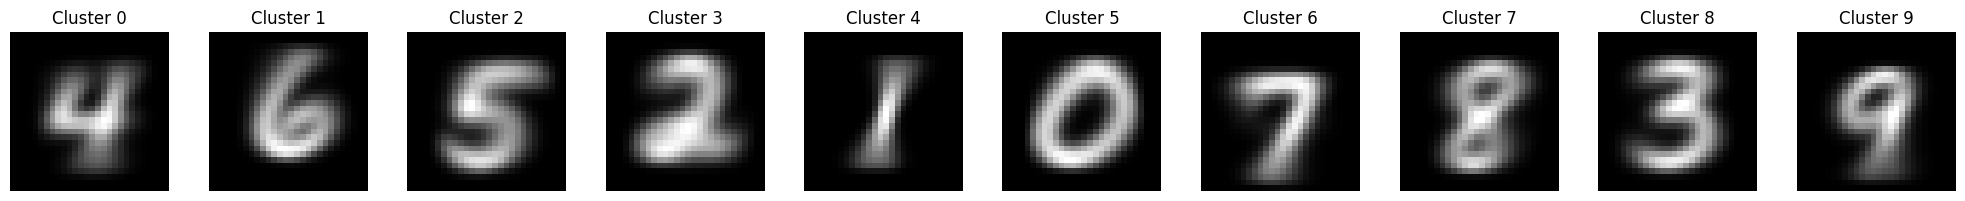

In [11]:
def plot_average_images(images, cluster_labels, num_clusters):
    
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 2, 2))

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices for the cluster
        if len(cluster_indices) > 0:
            avg_image = np.mean(images[cluster_indices], axis=0)  # Compute mean image
        else:
            avg_image = np.zeros_like(images[0])  # Handle empty clusters

        axes[cluster].imshow(avg_image.reshape(28, 28), cmap='gray')
        axes[cluster].axis('off')
        axes[cluster].set_title(f"Cluster {cluster}")

    plt.tight_layout()
    plt.show()

# Call function to display average images from clusters
plot_average_images(train_images, train_clusters, num_clusters)